# Start with local import and frame customization

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import sys
from IPython.display import HTML
sys.path.append('/home/rcendre/classification')

# Imports

In [3]:
import os
import sys
import itertools
import webbrowser
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pandas.io.formats.style import Styler
from scipy.stats import randint as randint
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import davies_bouldin_score
from toolbox.classification.common import Folds, IO, Tools
from toolbox.classification.parameters import ORL, Settings
from toolbox.models.builtin import Applications
from toolbox.transforms.common import PredictorTransform
from toolbox.transforms.labels import OrderedEncoder
from toolbox.transforms.signals import DWTTransform, FilterTransform, ScaleTransform, RatioTransform, FittingTransform
from toolbox.views.common import Views, ViewsTools
from toolbox.views.signals import SignalsViews

Using TensorFlow backend.


# Parameters

In [4]:
# Advanced parameters
validation = 4
statistics = ORL.get_statistics_keys()
settings = Settings.get_default_orl()

# Inputs

In [5]:
wavelength = np.arange(start=440, stop=960, step=1)
inputs = ORL.get_spectra(wavelength)
inputs['Label'] = inputs['Cancerous']
label_encoder = OrderedEncoder().fit(['Rest', 'Cancer'])

In [6]:
group_encoder = LabelEncoder().fit(inputs['Reference'])

In [7]:
inputs = Tools.transform(inputs, {'datum': 'Label'}, label_encoder, 'LabelEncode')
inputs = Tools.transform(inputs, {'datum': 'Reference'}, group_encoder, 'GroupEncode')
inputs = Folds.build_group_folds(inputs, {'datum': 'Datum', 'label_encode': 'LabelEncode', 'group': 'GroupEncode'}, validation)

# Statistics

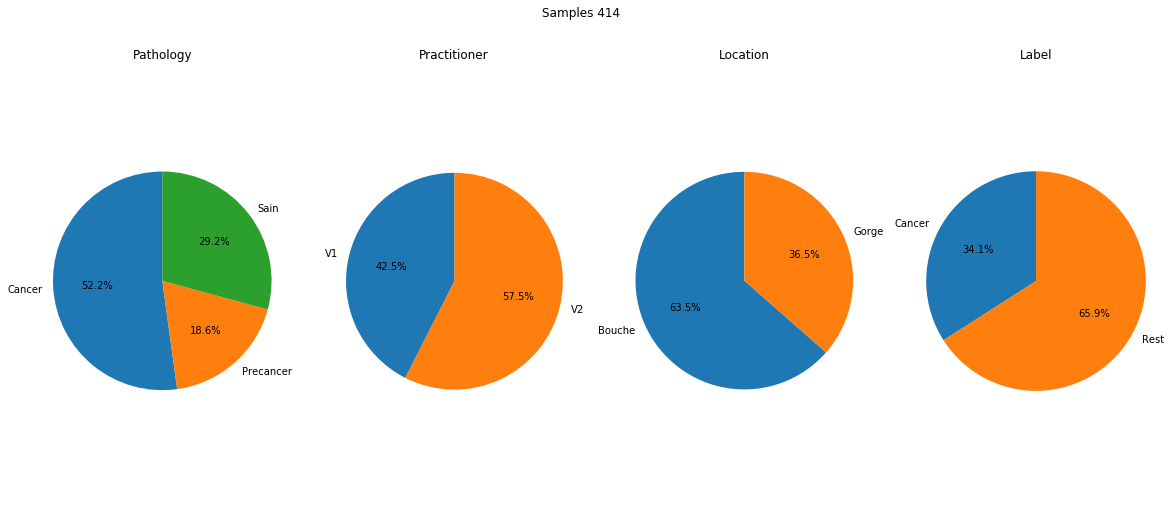

In [8]:
ViewsTools.plot_size((20, 8))
Views.statistics(inputs, statistics);

# Mean Analysis

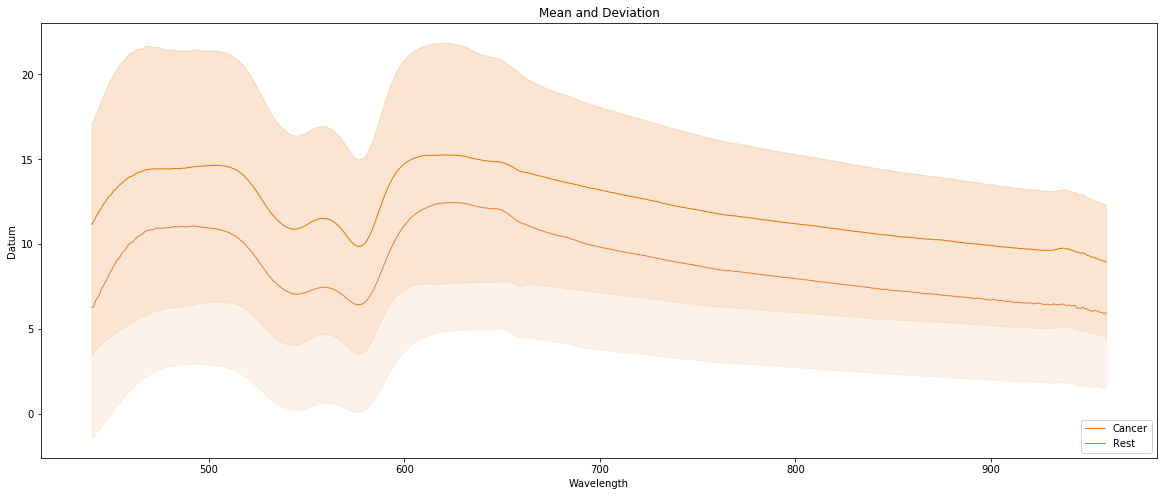

In [9]:
SignalsViews.mean_and_deviation(inputs, {'datum':'Datum', 'label':'Label', 'wavelength':'Wavelength'}, settings);

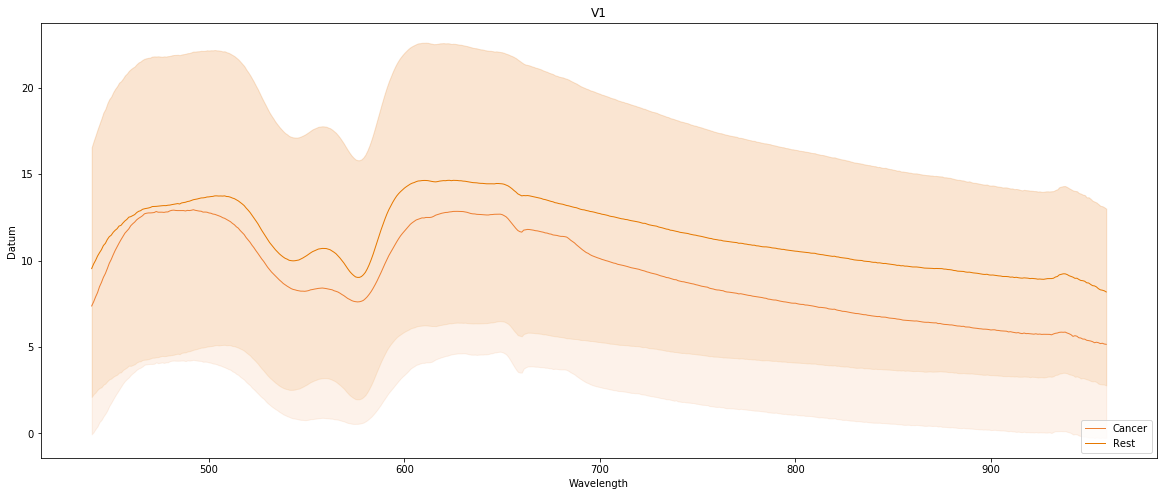

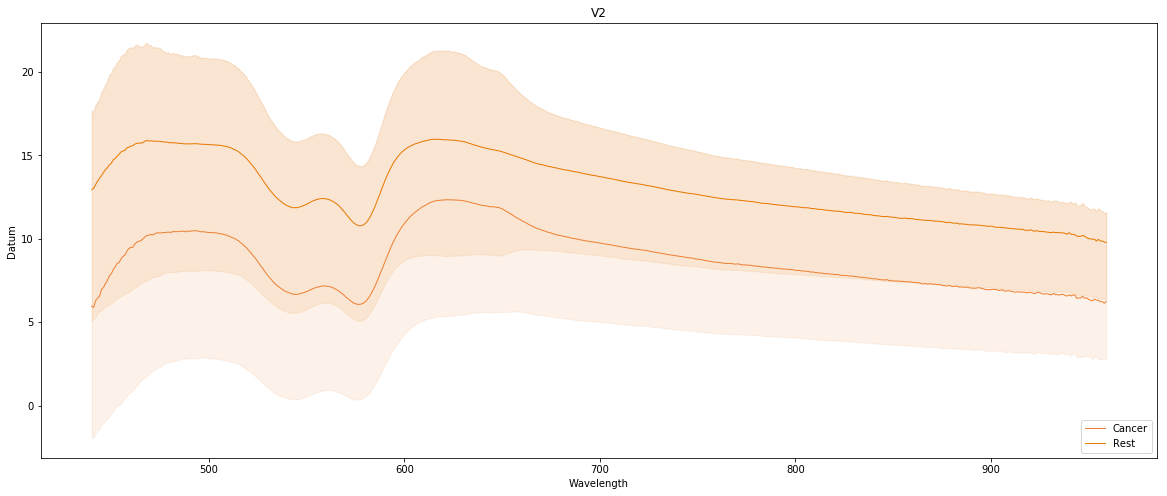

In [10]:
SignalsViews.mean_and_deviation(inputs[inputs['Practitioner']=='V1'], {'datum':'Datum', 'label':'Label', 'wavelength':'Wavelength'}, settings, 'V1');
SignalsViews.mean_and_deviation(inputs[inputs['Practitioner']=='V2'], {'datum':'Datum', 'label':'Label', 'wavelength':'Wavelength'}, settings, 'V2');

# Preprocessing

In [11]:
inputs = Tools.transform(inputs, {'datum': 'Datum'}, FilterTransform(5, 'avg'), 'Average')
inputs = Tools.transform(inputs, {'datum': 'Average'}, ScaleTransform('mean'), 'Scale')

# Preprocess - Mean Analysis

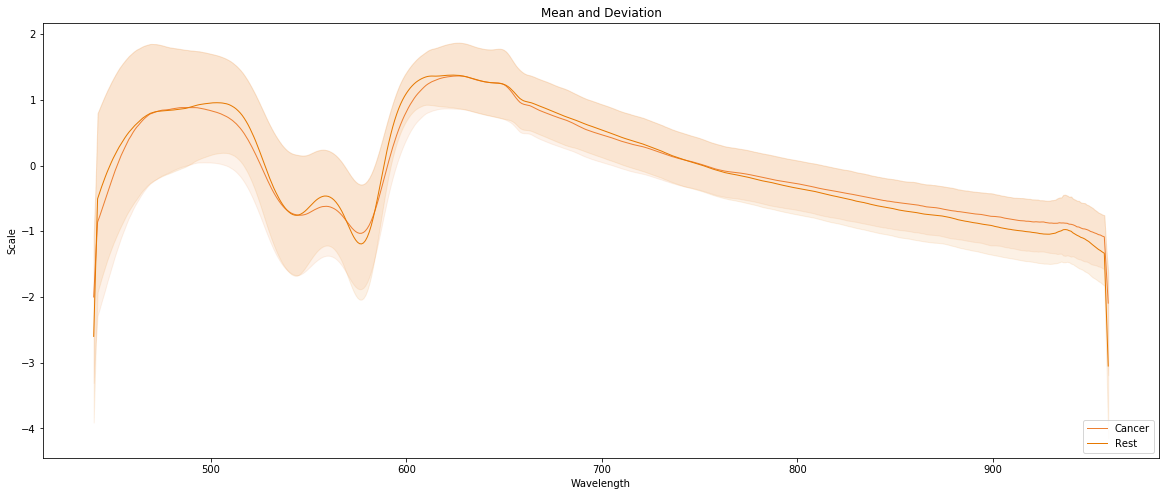

In [12]:
SignalsViews.mean_and_deviation(inputs, {'datum':'Scale', 'label':'Label', 'wavelength':'Wavelength'}, settings);

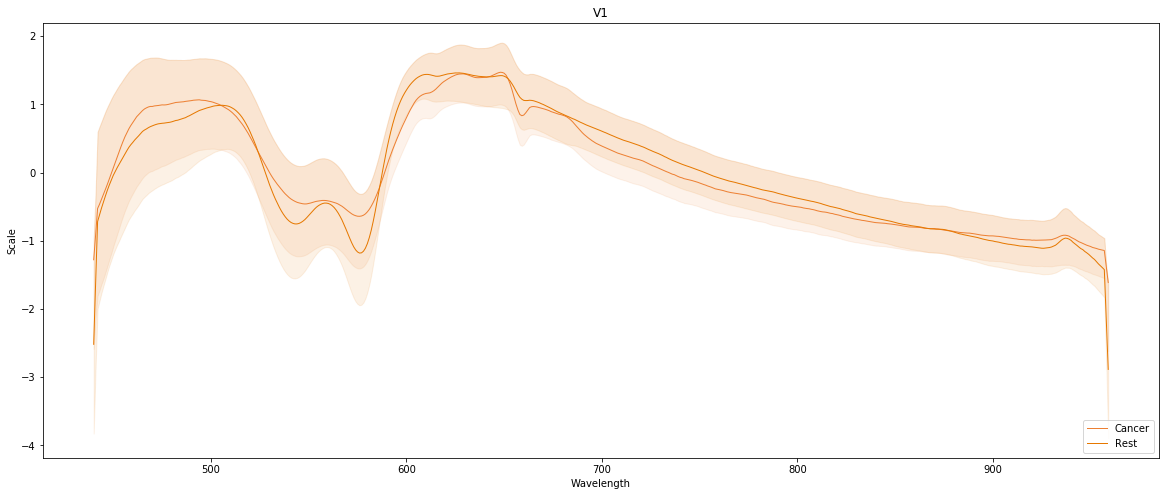

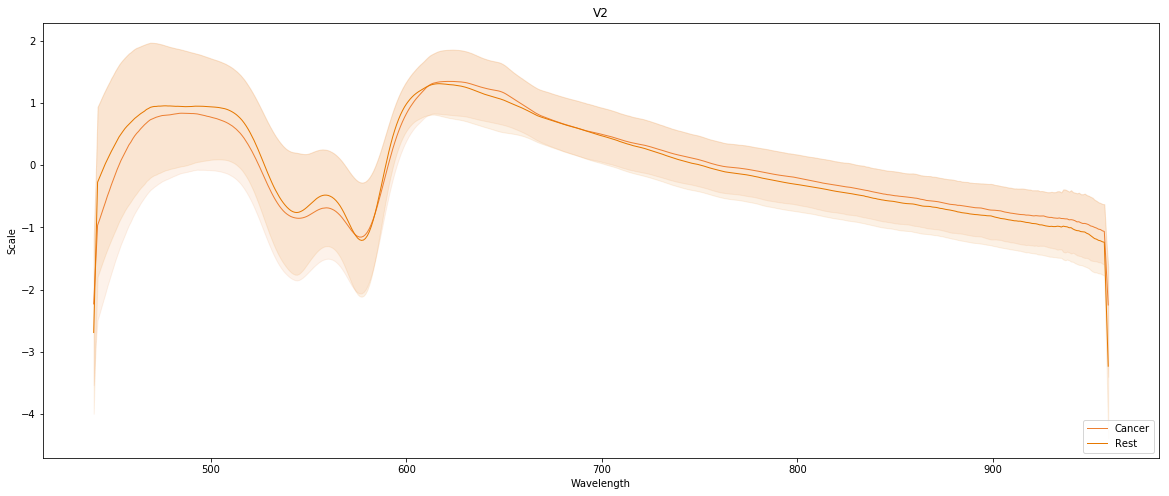

In [13]:
SignalsViews.mean_and_deviation(inputs[inputs['Practitioner']=='V1'], {'datum':'Scale', 'label':'Label', 'wavelength':'Wavelength'}, settings, 'V1');
SignalsViews.mean_and_deviation(inputs[inputs['Practitioner']=='V2'], {'datum':'Scale', 'label':'Label', 'wavelength':'Wavelength'}, settings, 'V2');

# Ratios Evaluation

## Model

In [14]:
model = SVC(kernel='linear', class_weight='balanced', probability=True)
grid = {'C': np.geomspace(0.01, 100, 5).tolist()}

## Litterature ratios
540 over 575 µm and 545 over 575 µm seems relevant

In [15]:
inputs = Tools.transform(inputs, {'datum': 'Scale'}, RatioTransform(ratios=[(540, 575), (545, 575)], wavelength=wavelength), 'LRatios')

In [16]:
inputs = Tools.evaluate(inputs, {'datum': 'LRatios', 'label_encode': 'LabelEncode'}, model, 'LRatios_SVM', grid=grid)

In [17]:
HTML(ViewsTools.dataframe_renderer([Views.report(ViewsTools.data_as(inputs, 'LRatios_SVM'), {'label_encode': 'LabelEncode', 'eval': 'LRatios_SVM'}, label_encoder),
                                    Views.report(ViewsTools.data_as(inputs, 'LRatios_SVM', as_train=True), {'label_encode': 'LabelEncode', 'eval': 'LRatios_SVM'}, label_encoder)],
                                    title=['Test - 540/575 and 545/575 Ratios classification performance.', 'Train - 540/575 and 545/575 Ratios classification performance']))

,f1-score,precision,recall,support
Rest,0.68±0.33,0.66±0.13,0.71±0.41,273.00±11.78
Cancer,0.30±0.20,0.33±0.19,0.28±0.40,141.00±11.05
micro avg,0.56±0.18,0.56±0.18,0.56±0.18,414.00±0.87
macro avg,0.49±0.10,0.49±0.11,0.49±0.01,414.00±0.87
weighted avg,0.55±0.21,0.54±0.15,0.56±0.18,414.00±0.87
,f1-score,precision,recall,support
Rest,0.70±0.09,0.68±0.10,0.73±0.14,819.00±35.33
Cancer,0.35±0.10,0.38±0.17,0.33±0.11,423.00±33.16
micro avg,0.59±0.06,0.59±0.06,0.59±0.06,1242.00±2.60
macro avg,0.53±0.02,0.53±0.07,0.53±0.02,1242.00±2.60


## Anova

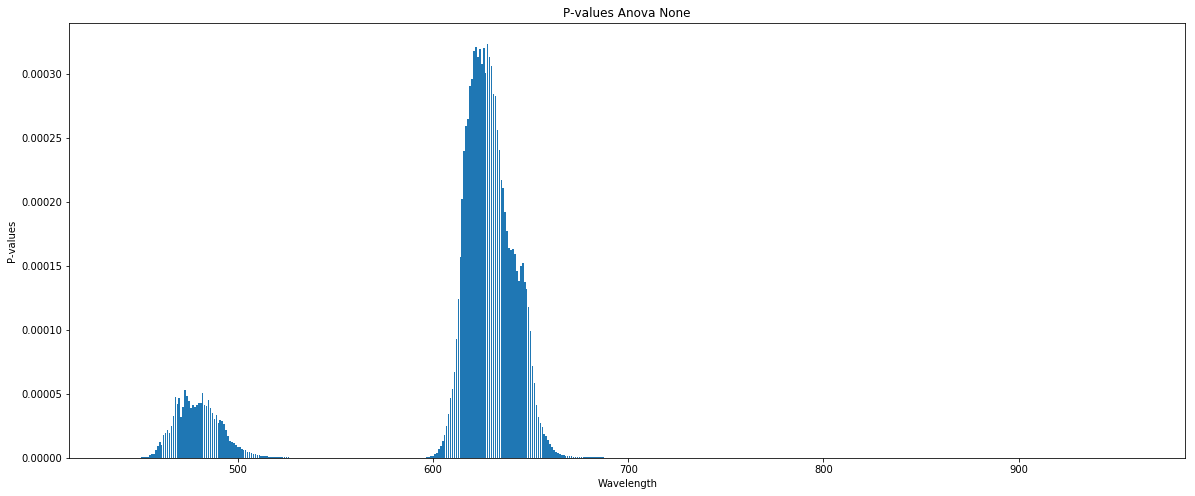

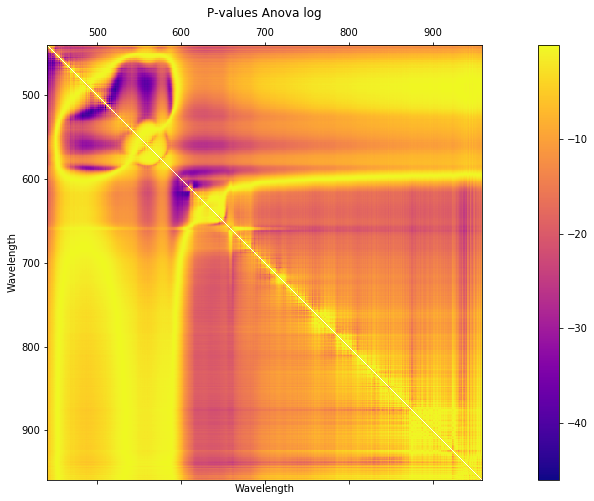

In [18]:
SignalsViews.analysis(inputs,  {'datum': 'Datum', 'wavelength': 'Wavelength', 'label_encode': 'Label'}, mode='Anova');
SignalsViews.analysis_relation(inputs,  {'datum': 'Datum', 'wavelength': 'Wavelength', 'label_encode': 'Label'}, scale='log', mode='Anova');

## Evaluate

In [19]:
inputs = Tools.transform(inputs, {'datum': 'Scale'}, RatioTransform(ratios=[(490, 525), (490, 560), (490, 590), (600, 620)], wavelength=wavelength), 'ORatios')

In [20]:
inputs = Tools.evaluate(inputs, {'datum': 'ORatios', 'label_encode': 'LabelEncode'}, model, 'ORatios_SVM', grid=grid)

In [21]:
HTML(ViewsTools.dataframe_renderer([Views.report(ViewsTools.data_as(inputs, 'ORatios_SVM'), {'label_encode': 'LabelEncode', 'eval': 'ORatios_SVM'}, label_encoder),
                                    Views.report(ViewsTools.data_as(inputs, 'ORatios_SVM', as_train=True), {'label_encode': 'LabelEncode', 'eval': 'ORatios_SVM'}, label_encoder)],
                                    title=['Test - 490/(525,560,590) and 600/620 Ratios classification performance.', 'Train - 490/(525,560,590) and 600/620 Ratios classification performance']))

,f1-score,precision,recall,support
Rest,0.79±0.09,0.74±0.11,0.86±0.06,273.00±11.78
Cancer,0.48±0.03,0.60±0.04,0.40±0.05,141.00±11.05
micro avg,0.71±0.09,0.71±0.09,0.71±0.09,414.00±0.87
macro avg,0.64±0.05,0.67±0.05,0.63±0.04,414.00±0.87
weighted avg,0.69±0.09,0.69±0.08,0.71±0.09,414.00±0.87
,f1-score,precision,recall,support
Rest,0.80±0.09,0.74±0.11,0.87±0.06,819.00±35.33
Cancer,0.50±0.00,0.63±0.08,0.42±0.04,423.00±33.16
micro avg,0.72±0.08,0.72±0.08,0.72±0.08,1242.00±2.60
macro avg,0.65±0.04,0.69±0.05,0.64±0.04,1242.00±2.60


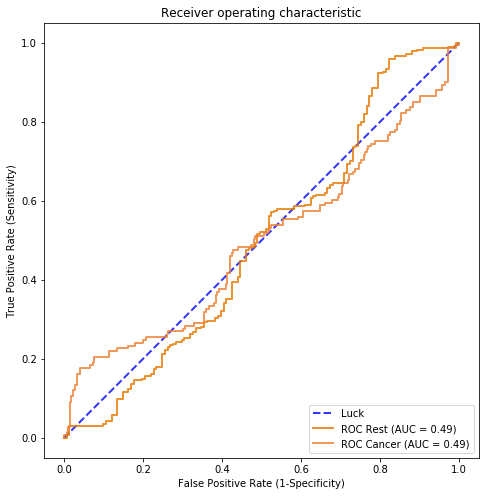

In [22]:
Views.receiver_operator_curves(ViewsTools.data_as(inputs, 'ORatios_SVM'), label_encoder, {'label_encode': 'LabelEncode', 'eval': 'ORatios_SVM'}, settings);

# PCA Evaluation

## Quick Analysis

Text(0.5, 1.0, 'PCA Analysis')

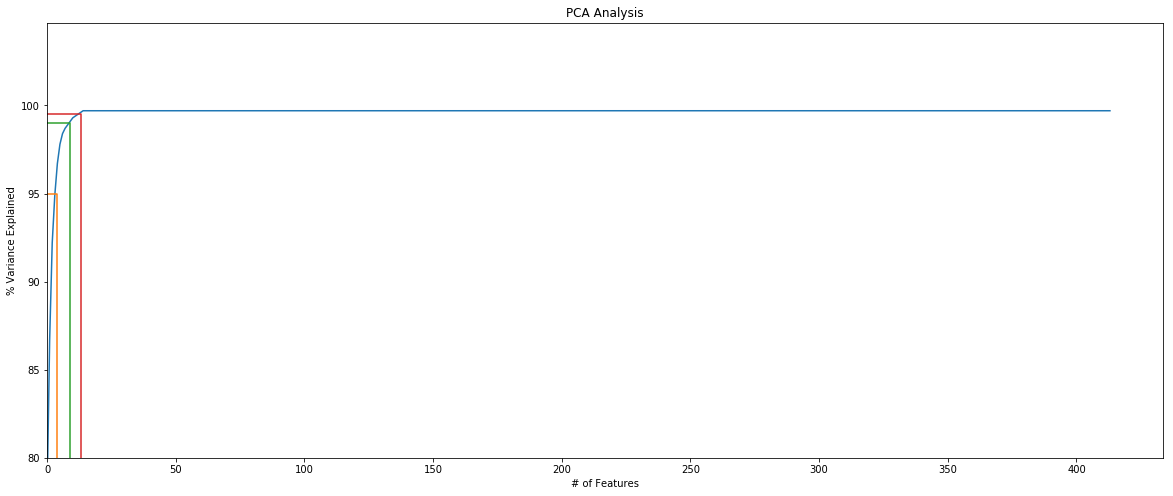

In [23]:
whole_pca = PCA().fit(np.array(inputs['Scale'].tolist()))
cumul = np.cumsum(np.round(whole_pca.explained_variance_ratio_, decimals=3)*100)
over_95 = np.argmax(cumul>95)
over_99 = np.argmax(cumul>99)
over_995 = np.argmax(cumul>99.5)
plt.plot(cumul)
plt.plot([0,over_95,over_95], [95,95,0])
plt.plot([0,over_99,over_99], [99,99,0])
plt.plot([0,over_995,over_995], [99.5,99.5,0])
plt.xlim(left=0)
plt.ylim(bottom=80)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')

## Model

In [24]:
pca95 = Pipeline([('pca', PCA(n_components=0.95)),
                  ('clf', SVC(kernel='linear', class_weight='balanced', probability=True))])
pca99 = Pipeline([('pca', PCA(n_components=0.99)),
                  ('clf', SVC(kernel='linear', class_weight='balanced', probability=True))])
pca995 = Pipeline([('pca', PCA(n_components=0.995)),
                  ('clf', SVC(kernel='linear', class_weight='balanced', probability=True))])
grid_pca = {'clf__C': np.geomspace(0.01, 100, 5).tolist()}

## Evaluate

In [25]:
inputs = Tools.evaluate(inputs, {'datum': 'Scale', 'label_encode': 'LabelEncode'}, pca95, 'PCA95_SVM', grid=grid_pca)
inputs = Tools.evaluate(inputs, {'datum': 'Scale', 'label_encode': 'LabelEncode'}, pca99, 'PCA99_SVM', grid=grid_pca)
inputs = Tools.evaluate(inputs, {'datum': 'Scale', 'label_encode': 'LabelEncode'}, pca99, 'PCA995_SVM', grid=grid_pca)

In [26]:
HTML(ViewsTools.dataframe_renderer([Views.report(ViewsTools.data_as(inputs, 'PCA95_SVM'), {'label_encode': 'LabelEncode', 'eval': 'PCA95_SVM'}, label_encoder),
                                    Views.report(ViewsTools.data_as(inputs, 'PCA95_SVM', as_train=True), {'label_encode': 'LabelEncode', 'eval': 'PCA95_SVM'}, label_encoder)],
                                    title=['Test - PCA 95% classification performance.', 'Train - PCA 95% classification performance.']))

,f1-score,precision,recall,support
Rest,0.69±0.11,0.72±0.14,0.67±0.09,273.00±11.78
Cancer,0.46±0.09,0.43±0.12,0.48±0.08,141.00±11.05
micro avg,0.61±0.10,0.61±0.10,0.61±0.10,414.00±0.87
macro avg,0.58±0.08,0.57±0.08,0.58±0.09,414.00±0.87
weighted avg,0.61±0.10,0.62±0.11,0.61±0.10,414.00±0.87
,f1-score,precision,recall,support
Rest,0.74±0.02,0.77±0.07,0.71±0.07,819.00±35.33
Cancer,0.55±0.11,0.52±0.17,0.60±0.05,423.00±33.16
micro avg,0.67±0.03,0.67±0.03,0.67±0.03,1242.00±2.60
macro avg,0.65±0.05,0.64±0.05,0.65±0.04,1242.00±2.60


In [27]:
HTML(ViewsTools.dataframe_renderer([Views.report(ViewsTools.data_as(inputs, 'PCA99_SVM'), {'label_encode': 'LabelEncode', 'eval': 'PCA99_SVM'}, label_encoder),
                                    Views.report(ViewsTools.data_as(inputs, 'PCA99_SVM', as_train=True), {'label_encode': 'LabelEncode', 'eval': 'PCA99_SVM'}, label_encoder)],
                                    title=['Test - PCA 99% classification performance.', 'Train - PCA 99% classification performance.']))

,f1-score,precision,recall,support
Rest,0.84±0.01,0.86±0.03,0.81±0.03,273.00±11.78
Cancer,0.71±0.12,0.68±0.14,0.75±0.11,141.00±11.05
micro avg,0.79±0.02,0.79±0.02,0.79±0.02,414.00±0.87
macro avg,0.77±0.06,0.77±0.06,0.78±0.05,414.00±0.87
weighted avg,0.79±0.02,0.80±0.01,0.79±0.02,414.00±0.87
,f1-score,precision,recall,support
Rest,0.87±0.03,0.89±0.03,0.86±0.04,819.00±35.33
Cancer,0.76±0.08,0.74±0.07,0.78±0.08,423.00±33.16
micro avg,0.83±0.03,0.83±0.03,0.83±0.03,1242.00±2.60
macro avg,0.82±0.04,0.81±0.04,0.82±0.04,1242.00±2.60


In [28]:
HTML(ViewsTools.dataframe_renderer([Views.report(ViewsTools.data_as(inputs, 'PCA995_SVM'), {'label_encode': 'LabelEncode', 'eval': 'PCA995_SVM'}, label_encoder),
                                    Views.report(ViewsTools.data_as(inputs, 'PCA995_SVM', as_train=True), {'label_encode': 'LabelEncode', 'eval': 'PCA995_SVM'}, label_encoder)],
                                    title=['Test - PCA 99.5% classification performance.', 'Train - PCA 99.5% classification performance.']))

,f1-score,precision,recall,support
Rest,0.84±0.01,0.86±0.03,0.81±0.03,273.00±11.78
Cancer,0.71±0.12,0.68±0.14,0.75±0.11,141.00±11.05
micro avg,0.79±0.02,0.79±0.02,0.79±0.02,414.00±0.87
macro avg,0.77±0.06,0.77±0.06,0.78±0.05,414.00±0.87
weighted avg,0.79±0.02,0.80±0.01,0.79±0.02,414.00±0.87
,f1-score,precision,recall,support
Rest,0.87±0.03,0.89±0.03,0.86±0.04,819.00±35.33
Cancer,0.76±0.08,0.74±0.07,0.78±0.08,423.00±33.16
micro avg,0.83±0.03,0.83±0.03,0.83±0.03,1242.00±2.60
macro avg,0.82±0.04,0.81±0.04,0.82±0.04,1242.00±2.60


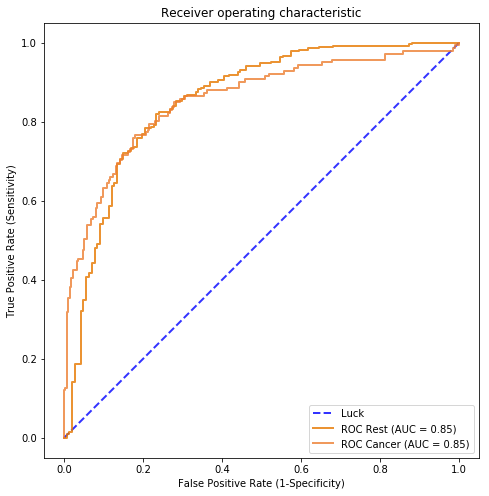

In [29]:
Views.receiver_operator_curves(ViewsTools.data_as(inputs, 'PCA99_SVM'), label_encoder, {'label_encode': 'LabelEncode', 'eval': 'PCA99_SVM'}, settings);

# DWT and Bags Evaluation

## Transform

In [30]:
inputs = Tools.transform(inputs, {'datum': 'Scale'}, DWTTransform(mode='db6', segment=80), 'DWT')

## Model

In [31]:
pipe_ahmed = Pipeline([('kmeans', KMeans(n_clusters=92, max_iter=50)),
                       ('clf', SVC(kernel='linear', class_weight='balanced', probability=True))])
grid_ahmed = {'clf__C': np.geomspace(0.01, 100, 5).tolist()}

In [32]:
inputs = Tools.evaluate(inputs, {'datum': 'DWT', 'label_encode': 'LabelEncode'}, pipe_ahmed, 'DWT_SVM', grid=grid_ahmed)

In [33]:
HTML(ViewsTools.dataframe_renderer([Views.report(ViewsTools.data_as(inputs, 'DWT_SVM'), {'label_encode': 'LabelEncode', 'eval': 'DWT_SVM'}, label_encoder),
                                    Views.report(ViewsTools.data_as(inputs, 'DWT_SVM', as_train=True), {'label_encode': 'LabelEncode', 'eval': 'DWT_SVM'}, label_encoder)],
                                    title=['Test - DWT+BOW classification performance.', 'Train - DWT+BOW classification performance.']))

,f1-score,precision,recall,support
Rest,0.83±0.06,0.84±0.09,0.82±0.04,273.00±11.78
Cancer,0.68±0.05,0.66±0.10,0.70±0.05,141.00±11.05
micro avg,0.78±0.04,0.78±0.04,0.78±0.04,414.00±0.87
macro avg,0.76±0.03,0.75±0.03,0.76±0.03,414.00±0.87
weighted avg,0.78±0.04,0.78±0.05,0.78±0.04,414.00±0.87
,f1-score,precision,recall,support
Rest,0.92±0.02,0.92±0.02,0.92±0.03,819.00±35.33
Cancer,0.84±0.08,0.84±0.07,0.84±0.10,423.00±33.16
micro avg,0.89±0.01,0.89±0.01,0.89±0.01,1242.00±2.60
macro avg,0.88±0.03,0.88±0.03,0.88±0.04,1242.00±2.60


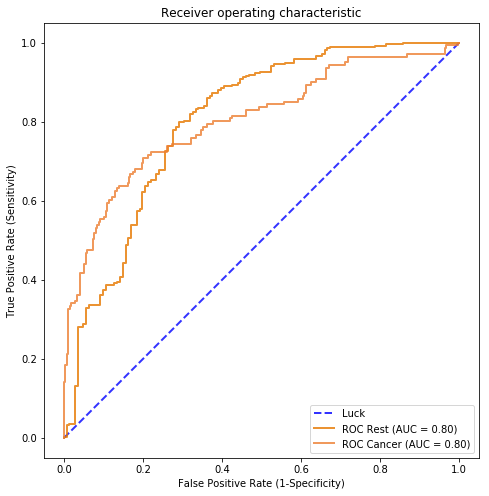

In [34]:
Views.receiver_operator_curves(ViewsTools.data_as(inputs, 'DWT_SVM'), label_encoder, {'label_encode': 'LabelEncode', 'eval': 'DWT_SVM'}, settings);

# Distribution Evaluation

## Analysis

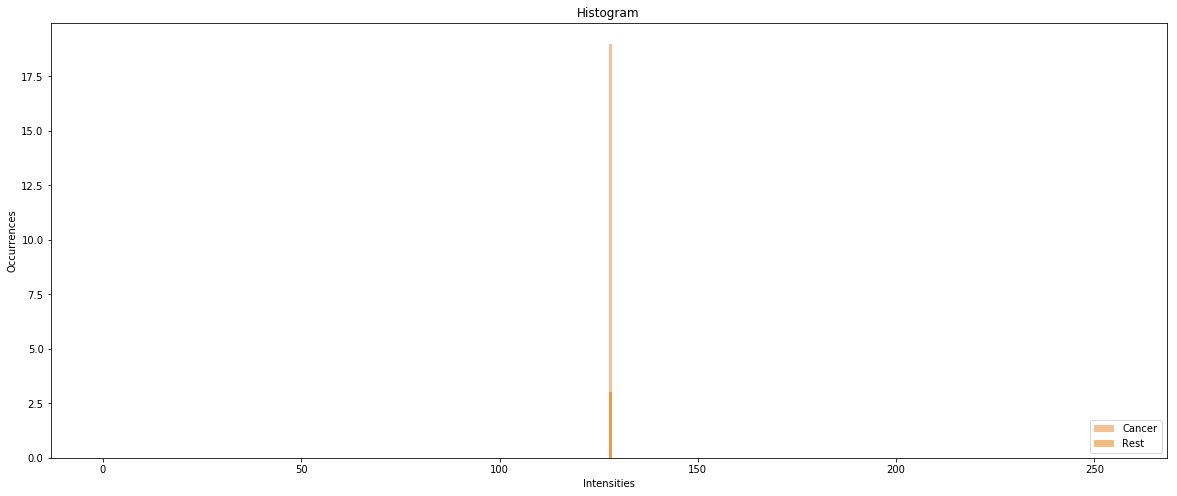

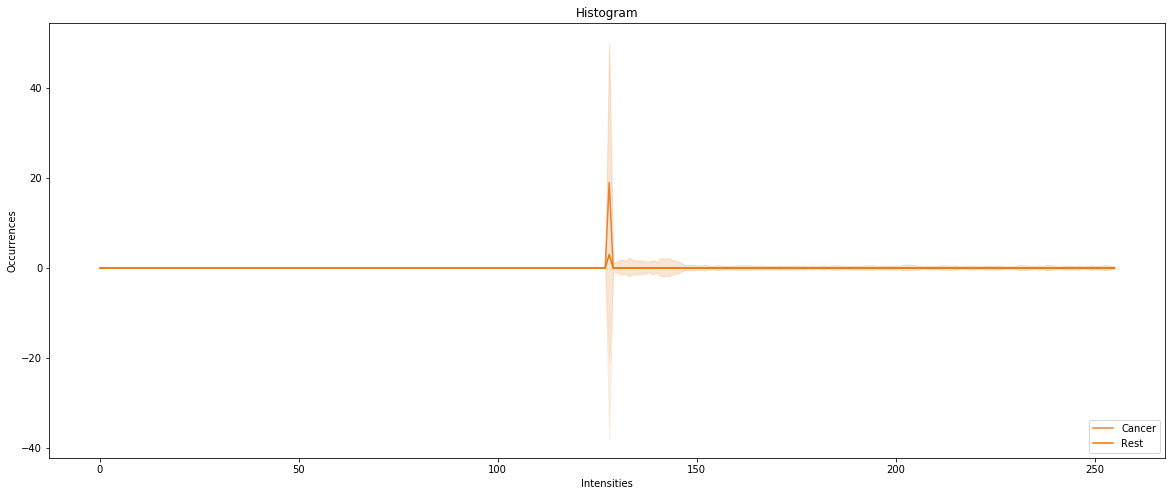

In [35]:
SignalsViews.histogram(inputs, {'datum': 'Datum', 'label': 'Label'}, settings);
SignalsViews.histogram(inputs, {'datum': 'Datum', 'label': 'Label'}, settings, mode='std');

## Transform

In [36]:
fit = FittingTransform().fit(np.array(inputs['Scale'].tolist()))
inputs = Tools.transform(inputs, {'datum': 'Scale'}, fit, 'Fit')

## Evaluate

In [37]:
inputs = Tools.evaluate(inputs, {'datum': 'Fit', 'label_encode': 'LabelEncode'}, model, 'Fit_SVM', grid=grid)

In [38]:
Views.report(ViewsTools.data_as(inputs, 'Fit_SVM'), {'label_encode': 'LabelEncode', 'eval': 'Fit_SVM'}, label_encoder)

,f1-score,precision,recall,support
Rest,0.65±0.33,0.61±0.27,0.69±0.43,273.00±11.78
Cancer,0.16±0.14,0.19±0.08,0.14±0.43,141.00±11.05
micro avg,0.50±0.19,0.50±0.19,0.50±0.19,414.00±0.87
macro avg,0.41±0.10,0.40±0.10,0.42±0.00,414.00±0.87
weighted avg,0.48±0.19,0.47±0.17,0.50±0.19,414.00±0.87


In [39]:
Views.report(ViewsTools.data_as(inputs, 'Fit_SVM', as_train=True), {'label_encode': 'LabelEncode', 'eval': 'Fit_SVM'}, label_encoder)

,f1-score,precision,recall,support
Rest,0.72±0.12,0.68±0.11,0.77±0.14,819.00±35.33
Cancer,0.33±0.16,0.39±0.18,0.29±0.14,423.00±33.16
micro avg,0.60±0.12,0.60±0.12,0.60±0.12,1242.00±2.60
macro avg,0.52±0.02,0.53±0.04,0.53±0.00,1242.00±2.60
weighted avg,0.59±0.09,0.58±0.06,0.60±0.12,1242.00±2.60


<BarContainer object of 17 artists>

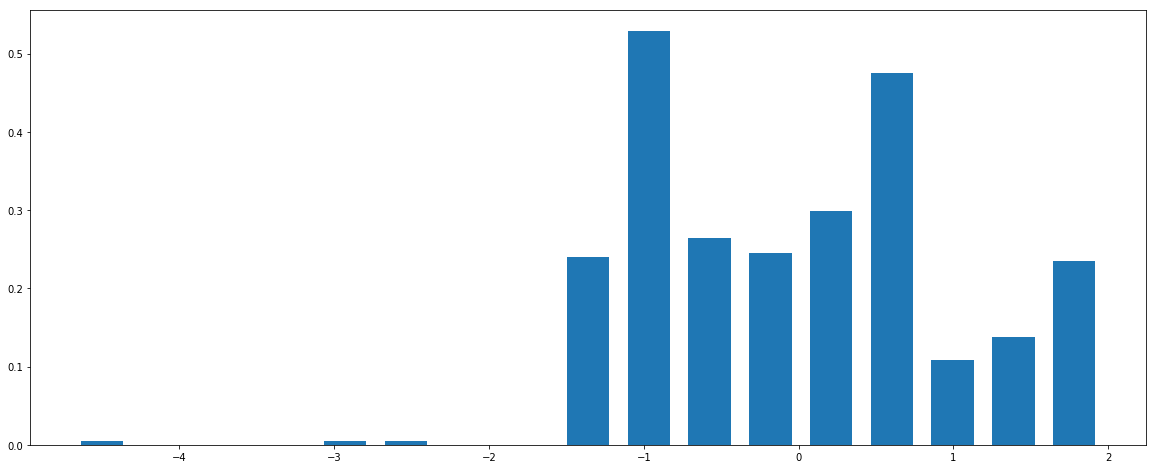

In [40]:
import scipy.stats as st
# plt.plot(inputs['Wavelength'][0], inputs['Datum'][0])
hist, bins = np.histogram(inputs['Scale'][7], bins='auto', density=True)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)

In [41]:
inputs

,Datum,Diagnosis,ID_Spectrum,Wavelength,Category,Reference,Identifier,Patient,Pathology,Practitioner,...,Fit_SVM_Features_3,Fit_SVM_Parameters_3,Fit_SVM_Predictions_4,Fit_SVM_Probabilities_4,Fit_SVM_Features_4,Fit_SVM_Parameters_4,Fit_SVM_Predictions,Fit_SVM_Probabilities,Fit_SVM_Features,Fit_SVM_Parameters
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009...",Cancer,0,"[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2.0,{'C': 0.01},0,"[0.6466874157366478, 0.35331258426335216]",2.0,{'C': 0.1},0.0,"[0.6466874157366478, 0.35331258426335216]",2.0,{'C': 0.1}
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.276...",Cancer,1,"[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2.0,{'C': 0.01},0,"[0.6466874157366478, 0.35331258426335216]",2.0,{'C': 0.1},0.0,"[0.6466874157366478, 0.35331258426335216]",2.0,{'C': 0.1}
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Cancer,2,"[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2.0,{'C': 0.01},0,"[0.6466874157366478, 0.35331258426335216]",2.0,{'C': 0.1},0.0,"[0.6466874157366478, 0.35331258426335216]",2.0,{'C': 0.1}
3,"[20.320190215924416, 20.92858036437247, 22.484...",Cancer,3,"[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2.0,{'C': 0.01},0,"[0.6466874157366478, 0.35331258426335216]",2.0,{'C': 0.1},0.0,"[0.6466874157366478, 0.35331258426335216]",2.0,{'C': 0.1}
4,"[7.8820947368421095, 8.048337179487184, 8.2492...",Sain,4,"[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2.0,{'C': 0.01},0,"[0.6466874157366472, 0.3533125842633528]",2.0,{'C': 0.1},0.0,"[0.6466874157366472, 0.3533125842633528]",2.0,{'C': 0.1}
5,"[21.228032186234824, 21.88160620782726, 22.115...",Sain,5,"[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,1_K.F,1,K.F,Cancer,V1,...,2.0,{'C': 0.01},0,"[0.6466874157366478, 0.35331258426335216]",2.0,{'C': 0.1},0.0,"[0.6466874157366478, 0.35331258426335216]",2.0,{'C': 0.1}
6,"[1.7572229419703107, 1.9101871794871765, 2.146...",Cancer,0,"[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,2_V.M,2,V.M,Cancer,V1,...,2.0,{'C': 0.01},0,"[0.6466874157366478, 0.35331258426335216]",2.0,{'C': 0.1},0.0,"[0.6125065416946499, 0.3874934583053501]",2.0,{'C': 0.01}
7,"[31.07786673414304, 31.339617813765184, 30.993...",Cancer,1,"[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,2_V.M,2,V.M,Cancer,V1,...,2.0,{'C': 0.01},0,"[0.6466874157366472, 0.3533125842633528]",2.0,{'C': 0.1},0.0,"[0.6125065416946499, 0.3874934583053501]",2.0,{'C': 0.01}
8,"[1.5860779352226804, 1.4342384615384574, 1.891...",Cancer,2,"[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,2_V.M,2,V.M,Cancer,V1,...,2.0,{'C': 0.01},0,"[0.6466874157366478, 0.35331258426335216]",2.0,{'C': 0.1},0.0,"[0.6125065416946499, 0.3874934583053501]",2.0,{'C': 0.01}
9,"[0.35751930499324736, 0.7758653711201083, 0.94...",Sain,3,"[440, 441, 442, 443, 444, 445, 446, 447, 448, ...",Patients,2_V.M,2,V.M,Cancer,V1,...,2.0,{'C': 0.01},0,"[0.6466874157366478, 0.35331258426335216]",2.0,{'C': 0.1},0.0,"[0.6125065416946499, 0.3874934583053501]",2.0,{'C': 0.01}
